In [11]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

In [7]:
dat = sm.datasets.get_rdataset("Guerry", "HistData").data

In [8]:
results = smf.ols('Lottery ~ Literacy + np.log(Pop1831)', data=dat).fit()

In [10]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Lottery   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     22.20
Date:                Fri, 24 May 2024   Prob (F-statistic):           1.90e-08
Time:                        10:30:11   Log-Likelihood:                -379.82
No. Observations:                  86   AIC:                             765.6
Df Residuals:                      83   BIC:                             773.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         246.4341     35.233      6.995      0.000     176.358     316.510
Literacy           -0.4889      0.128     -3.832      0.000      -0.743      -0.235
np.log(Pop1831)   -31.3114      5.977     -5.239      0.000     -43.199     -19.424
==============================================================================
Omnibus:                        3.713   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.156   Jarque-Bera (JB):                3.394
Skew:                          -0.487   Prob(JB):                        0.183
Kurtosis:                       3.003   Cond. No.                         702.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## MV_signuture sample data

In [18]:
import os
import requests
import pandas as pd
import numpy as np

# Sample event
event = {
    'queryStringParameters': {
        'project_id': '123',
        'independent_variable': 'temp,humidity',
        'metersIds': 'meter1,meter2',
        'buildingId': '456'
    },
    'headers': {
        'Authorization': 'Bearer some-token'
    }
}

# Sample data for con
sample_con = pd.DataFrame({
    'fuelType': ['Electricity', 'Electricity', 'Gas', 'Gas'],
    'consumption_raw': [100, 150, 200, 250],
    'project_id': [123, 123, 123, 123],
    'month': ['2023-01', '2023-02', '2023-01', '2023-02']
})

# Sample data for variable
sample_variable = pd.DataFrame({
    'topic': ['temp', 'humidity', 'temp', 'humidity'],
    'value': [25, 60, 30, 65],
    'timestamp': ['2023-01-01', '2023-01-01', '2023-02-01', '2023-02-01']
})

# Mock functions and objects
def get_params(df, target_y, p):
    # Mock function to return dummy regression parameters
    return [0.9, 0.85, 0.1, 0.05, list(df.columns), [0.3, 0.5], 'R-squared message', 'NMBE message', 'CV RMSE message', list(np.round(target_y * 0.9, 2)), 'Other data check message']

class QueryInterface:
    def query(self, query):
        # Mock function to return dummy data
        return sample_variable.to_dict('records')

# Setting up environment variable
os.environ['UBMS_API_URL'] = 'https://mock-api-url.com'

# Mock API request
def mock_post(url, headers, json):
    # Mock response from the API
    return MockResponse()

class MockResponse:
    def json(self):
        return {
            'data': sample_con.to_dict(orient='records')
        }

requests.post = mock_post

# Sample Lambda function execution
def mv_signature(event, context):
    qs = event['queryStringParameters']
    if qs is None:
        return
    project_id = int(qs['project_id'])
    input_variable = list(qs['independent_variable'].split(','))
    meter_id = list(qs['metersIds'].split(','))
    building_id = int(qs['buildingId'])
    headers_from = event['headers']

    headers = {'Authorization': headers_from['Authorization']}
    main_api = os.environ['UBMS_API_URL'] + '/baseline/total?'
    data = {
        "projectIds": [project_id], "meterIds": meter_id,
        "fields": ['consumption_raw'], "groups": ["project_id", "fuelType", "month"], "flatten": True
    }
    r = requests.post(url=main_api, headers=headers, json=data)
    response = r.json()
    con = pd.json_normalize(response, 'data')

    interface = QueryInterface()
    test = 'Baseline'
    query = "select topic,value,timestamp from baseline where project_id={} and building_id={} and topic like '%{}%'".format((project_id), (building_id), test)
    data = interface.query(query)
    variable = pd.json_normalize(data)

    if len(variable) == 0:
        fuel_message = "There are missing records for your chosen variables in the database. Please input the data or select other variables as your default model"
        final = pd.DataFrame([{'fuel_type': '', 'r_squared': 0, 'adjusted_r_squared': 0, 
                               'nmbe': 0, 'cv_rmse': 0, 'variable': input_variable, 'signature_coef': [0, 0],
                               'r_squared_m': 'Please note that input data is missing', 'nmbe_m': 'Please note that input data is missing', 
                               'cv_rmse_m': 'Please note that input data is missing', 'fuel_message': fuel_message,
                               'y_pred': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'data_check': 'Please note that input data is missing'}])
    else:
        db_variable = list(variable['topic'].unique())
        x_variable = set(input_variable) & set(db_variable)
        if len(x_variable) != len(input_variable):
            conflict = [i for i in input_variable if i not in db_variable]
            fuel_message = "There are missing records for your chosen variables " + str(conflict) + " in the database. Please input the data or select other variables as your default model"
            final = pd.DataFrame([{'fuel_type': '', 'r_squared': 0, 'adjusted_r_squared': 0, 
                                   'nmbe': 0, 'cv_rmse': 0, 'variable': input_variable, 'signature_coef': [0, 0],
                                   'r_squared_m': 'Please note that input data is missing', 'nmbe_m': 'Please note that input data is missing', 
                                   'cv_rmse_m': 'Please note that input data is missing', 'fuel_message': fuel_message,
                                   'y_pred': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'data_check': 'Please note that input data is missing'}])
        elif len(con) == 0:
            fuel_message = "Baseline consumptions are missing. Please double check your input records."
            final = pd.DataFrame([{'fuel_type': '', 'r_squared': 0, 'adjusted_r_squared': 0, 
                                   'nmbe': 0, 'cv_rmse': 0, 'variable': input_variable, 'signature_coef': [0, 0],
                                   'r_squared_m': 'Please note that there is no consumption data', 'nmbe_m': 'Please note that there is no consumption data', 
                                   'cv_rmse_m': 'Please note that there is no consumption data', 'fuel_message': fuel_message,
                                   'y_pred': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'data_check': 'Please note that there is no consumption data'}])
        else:
            con['consumption_raw'] = con['consumption_raw'].astype(float)
            p = len(input_variable)
            df = pd.DataFrame()
            for item in x_variable:
                df[item] = variable[variable['topic'] == item]['value'].values
            final = []
            fuel_message = {}
            for item in con['fuelType'].unique():
                target_y = con[con['fuelType'] == item]['consumption_raw'].values
                if np.mean(target_y) == 0 or len(target_y) < 12:
                    message = 'Please note that your consumption data for ' + item + ' is missing'
                    res = {'fuel_type': item, 'r_squared': 0, 'adjusted_r_squared': 0, 
                           'nmbe': 0, 'cv_rmse': 0, 'variable': list(df.columns.values), 'signature_coef': [0, 0],
                           'r_squared_m': 'Please note that your consumption data is missing', 'nmbe_m': 'Please note that your consumption data is missing', 
                           'cv_rmse_m': 'Please note that your consumption data is missing', 'fuel_message': message,
                           'y_pred': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'data_check': 'Please note that your consumption data is missing'}
                else:
                    message = 'Regression model generated'
                    ols_m = get_params(df, target_y, p)
                    res = {'fuel_type': item, 'r_squared': ols_m[0], 'adjusted_r_squared': ols_m[1], 'nmbe': ols_m[2], 'cv_rmse': ols_m[3],  'variable': ols_m[4], 'signature_coef': ols_m[5],
                           'r_squared_m': ols_m[6], 'nmbe_m': ols_m[7], 'cv_rmse_m': ols_m[8], 'fuel_message': message, 'y_pred': ols_m[9], 'y': list(np.round(target_y, 2)), 'data_check': ols_m[11]}
                final.append(res)
                fuel_message[item] = message
            final = pd.DataFrame(final).fillna(0)

    body = {
        "message": fuel_message,
        "input": event,
        "payload": final.to_dict("records"),
    }

    return body

# Test the function
result = mv_signature(event, None)
print(result)


{'message': {'Electricity': 'Please note that your consumption data for Electricity is missing', 'Gas': 'Please note that your consumption data for Gas is missing'}, 'input': {'queryStringParameters': {'project_id': '123', 'independent_variable': 'temp,humidity', 'metersIds': 'meter1,meter2', 'buildingId': '456'}, 'headers': {'Authorization': 'Bearer some-token'}}, 'payload': [{'fuel_type': 'Electricity', 'r_squared': 0, 'adjusted_r_squared': 0, 'nmbe': 0, 'cv_rmse': 0, 'variable': ['humidity', 'temp'], 'signature_coef': [0, 0], 'r_squared_m': 'Please note that your consumption data is missing', 'nmbe_m': 'Please note that your consumption data is missing', 'cv_rmse_m': 'Please note that your consumption data is missing', 'fuel_message': 'Please note that your consumption data for Electricity is missing', 'y_pred': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'y': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'data_check': 'Please note that your consumption data is missing'}, {'fuel_type': 'Gas', 'r_

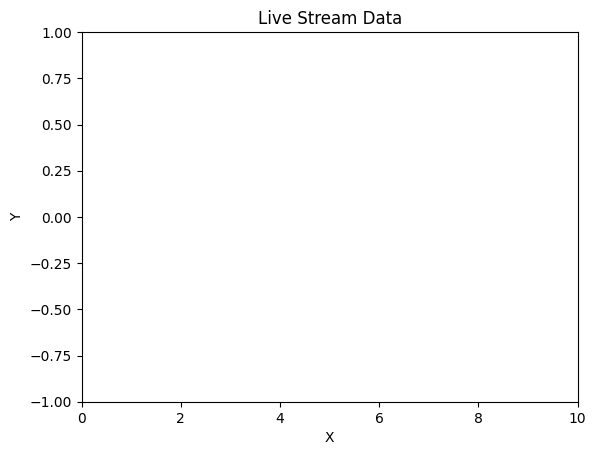

In [21]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Function to generate random data
def generate_data():
    x = np.arange(0, 10, 0.1)
    y = np.sin(x)
    return x, y

# Function to update the plot
def update_plot(frame):
    x, y = generate_data()
    line.set_data(x, y)
    return line,

# Create a figure and axis
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2)

# Set plot properties
ax.set_xlim(0, 10)
ax.set_ylim(-1, 1)
ax.set_title('Live Stream Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
    
# Create an animation
ani = animation.FuncAnimation(fig, update_plot, frames=200, interval=100)

# Show the plot
plt.show()
